In [1]:
import cirq
from quchem.Hamiltonian_Generator_Functions import *
from quchem.Graph import *
### HAMILTONIAN start
Molecule = 'H2'#'LiH'
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., 0.74))]#[('Li', (0., 0., 0.)), ('H', (0., 0., 1.45))]
num_shots = 10000
basis = 'sto-3g'


### Get Hamiltonian
Hamilt = Hamiltonian(Molecule,
                     run_scf=1, run_mp2=1, run_cisd=1, run_ccsd=1, run_fci=1,
                     basis=basis,
                     multiplicity=1,
                     geometry=geometry)  # normally None!
QubitHamiltonian = Hamilt.Get_Qubit_Hamiltonian(threshold=None, transformation='JW')
### HAMILTONIAN end

#####################################

Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)

commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)
anti_commuting_sets

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1160.08it/s]


{0: [(0.1686889816869329+0j) [Z0 Z1]],
 1: [(0.174412876106516+0j) [Z2 Z3]],
 2: [(0.12062523481381837+0j) [Z0 Z2]],
 3: [(0.16592785032250768+0j) [Z1 Z2]],
 4: [(-0.09706626861762624+0j) []],
 5: [(0.12062523481381837+0j) [Z1 Z3]],
 6: [(0.16592785032250768+0j) [Z0 Z3]],
 7: [(-0.2234315367466397+0j) [Z2], (0.04530261550868928+0j) [Y0 X1 X2 Y3]],
 8: [(-0.04530261550868928+0j) [Y0 Y1 X2 X3], (0.17141282639402405+0j) [Z0]],
 9: [(0.04530261550868928+0j) [X0 Y1 Y2 X3], (0.171412826394024+0j) [Z1]],
 10: [(-0.2234315367466397+0j) [Z3], (-0.04530261550868928+0j) [X0 X1 Y2 Y3]]}

In [3]:
from quchem.Unitary_partitioning import * 

In [3]:
# # ANSATZ CIRCUIT
# from quchem.Ansatz_Generator_Functions import *
# ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)

# Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()

# Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,
#                                                                                                                     transformation='JW')

# full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
#              Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)

# ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

In [4]:
from quchem.Simulating_Quantum_Circuit import *
from quchem.Ansatz_Generator_Functions import *
from openfermion.ops import QubitOperator

def H2_ansatz(theta):
    HF_circ = [cirq.X.on(cirq.LineQubit(0)), cirq.X.on(cirq.LineQubit(1))]
    
    full_exp_circ_obj = full_exponentiated_PauliWord_circuit(QubitOperator('Y0 X1 X2 X3', -1j), theta)
    UCCSD_circ = cirq.Circuit(cirq.decompose_once((full_exp_circ_obj(*cirq.LineQubit.range(full_exp_circ_obj.num_qubits())))))
    full_circuit = cirq.Circuit([*HF_circ, *UCCSD_circ.all_operations()])
    
    return full_circuit
    
H2_ansatz(np.pi)    

0: ───X───Rx(0.5π)───@──────────────────────────────@───Rx(-0.5π)───
                     │                              │
1: ───X───H──────────X───@──────────────────────@───X───H───────────
                         │                      │
2: ───H──────────────────X───@──────────────@───X───H───────────────
                             │              │
3: ───H──────────────────────X───Rz(2.0π)───X───H───────────────────

In [6]:
n_shots=10_000

def GIVE_ENERGY(THETA):
    H2_ansatz_cirq_circuit = H2_ansatz(THETA)
    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, H2_ansatz_cirq_circuit, n_shots,
                                   S_key_dict={7:1, 8:1, 9:1, 10:1})#None)
    
    return VQE_exp_UP.Calc_Energy()
GIVE_ENERGY(np.pi)

-1.1178258069869513

-1.1371267723731786
-1.13728383451232
-1.1372838344855132


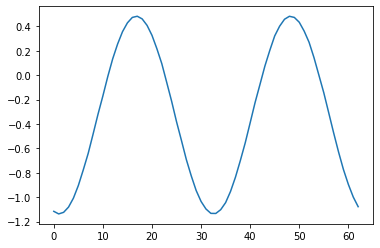

In [7]:
### full angle scan

import matplotlib.pyplot as plt
%matplotlib inline

theta_list = np.arange(0,2*np.pi, 0.1)

E_list = [GIVE_ENERGY(theta) for theta in theta_list]

plt.plot(E_list)
print(min(E_list))
print(Hamilt.molecule.ccsd_energy)
print(Hamilt.molecule.fci_energy)

0: Input_to_Funct: [0.9]: Output: -0.3189845513551869
1: Input_to_Funct: [0.7]: Output: -0.6405559727681428
2: Input_to_Funct: [0.3]: Output: -1.0794301608341121
3: Input_to_Funct: [0.1]: Output: -1.137020393398523
4: Input_to_Funct: [0.1]: Output: -1.1370558530567416
5: Input_to_Funct: [0.1]: Output: -1.1369140144238676
6: Input_to_Funct: [0.125]: Output: -1.1369848691262088
7: Input_to_Funct: [0.1125]: Output: -1.1372382031674162
8: Input_to_Funct: [0.1125]: Output: -1.137359769907866
9: Input_to_Funct: [0.1125]: Output: -1.1370659566959058
10: Input_to_Funct: [0.1140625]: Output: -1.1372888505914291
11: Input_to_Funct: [0.1140625]: Output: -1.1373547180882837
12: Input_to_Funct: [0.1140625]: Output: -1.1372382031674162
13: Input_to_Funct: [0.11484375]: Output: -1.1372989865376413
14: Input_to_Funct: [0.11484375]: Output: -1.137359769907866
15: Input_to_Funct: [0.11484375]: Output: -1.1372382031674162
16: Input_to_Funct: [0.11484375]: Output: -1.1373800418002902
17: Input_to_Funct: [

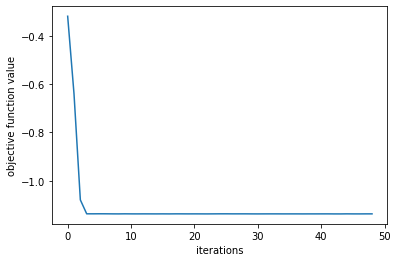

In [7]:
### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[1]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()

# full ansatz circuit

In [8]:
Hamiltonian_graph_obj = Openfermion_Hamiltonian_Graph(QubitHamiltonian)
commutativity_flag = 'AC' ## <- defines relationship between sets!!!
plot_graph = False
Graph_colouring_strategy='largest_first'
anti_commuting_sets = Hamiltonian_graph_obj.Get_Clique_Cover_as_QubitOp(commutativity_flag, Graph_colouring_strategy=Graph_colouring_strategy, plot_graph=plot_graph)


# ANSATZ CIRCUIT
from quchem.Ansatz_Generator_Functions import *
ansatz_obj = Ansatz(Hamilt.molecule.n_electrons, Hamilt.molecule.n_qubits)
Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops, theta_parameters_ia, theta_parameters_ijab = ansatz_obj.Get_ia_and_ijab_terms()
Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab = ansatz_obj.UCCSD_single_trotter_step(Sec_Quant_CC_ia_ops, Sec_Quant_CC_ijab_ops,transformation='JW')
full_ansatz_Q_Circ = Ansatz_Circuit(Qubit_Op_list_Second_Quant_CC_Ops_ia, Qubit_Op_list_Second_Quant_CC_Ops_ijab,
             Hamilt.molecule.n_qubits, Hamilt.molecule.n_electrons)
ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

Building Graph Edges: 100%|##########| 15/15 [00:00<00:00, 1983.87it/s]


0: Input_to_Funct: [3.   3.   3.15]: Output: -1.115611829648178
1: Input_to_Funct: [3.125 2.975 3.125]: Output: -1.1156371856672325
2: Input_to_Funct: [3.0625 2.9875 3.1375]: Output: -1.116387019537595
3: Input_to_Funct: [3.0625 2.9875 3.1375]: Output: -1.1169391216892008
4: Input_to_Funct: [3.0625 2.9875 3.1375]: Output: -1.1150749152623665
5: Input_to_Funct: [3.0625 2.9875 3.1375]: Output: -1.1158702801230638
6: Input_to_Funct: [3.0625 2.9875 3.1375]: Output: -1.1176181008572224
7: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1160931094044908
8: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1171164845943893
9: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1171925203445043
10: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1174660616640402
11: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1167416161197798
12: Input_to_Funct: [3.06006944 2.98923611 3.16423611]: Output: -1.1163667153381227
13: Input_to_

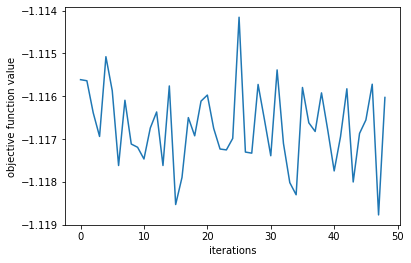

In [12]:
def GIVE_ENERGY(theta_ia_theta_jab_list):
    theta_ia = theta_ia_theta_jab_list[:len(theta_parameters_ia)]
    theta_ijab = theta_ia_theta_jab_list[len(theta_parameters_ia):]
    
    ansatz_cirq_circuit = full_ansatz_Q_Circ.Get_Full_HF_UCCSD_QC(theta_parameters_ia, theta_parameters_ijab)

    VQE_exp_UP = VQE_Experiment_UP(anti_commuting_sets, ansatz_cirq_circuit, n_shots, S_key_dict=None)#{7:1, 8:1, 9:0, 10:0})
    
    return VQE_exp_UP.Calc_Energy()

### optimizer
from quchem.Scipy_Optimizer import *
# THETA_params = [*theta_parameters_ia, *theta_parameters_ijab]
THETA_params=[3,3,3]
GG = Optimizer(GIVE_ENERGY, THETA_params, 'Nelder-Mead', store_values=True, display_iter_steps=True,
               tol=1e-5,
               display_convergence_message=True)
GG.get_env(50)
GG.plot_convergence()
plt.show()